/tmp/ipykernel_53056/80125676.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_53056/80125676.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_53056/80125676.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_53056/80125676.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_53056/80125676.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


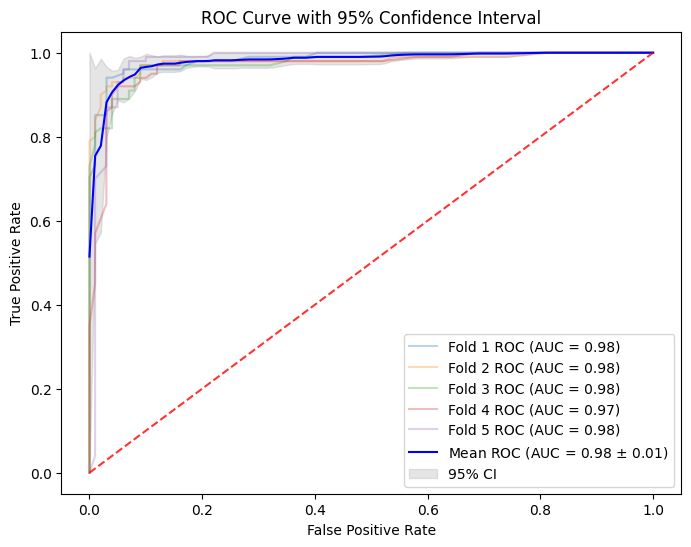

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# 生成数据
X, y = make_classification(n_samples=1000, n_classes=2, random_state=20)

# 模型
classifier = RandomForestClassifier(random_state=42)

# 使用StratifiedKFold进行交叉验证
cv = StratifiedKFold(n_splits=5)

# 存储结果
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    probas_ = classifier.predict_proba(X[test])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, alpha=0.3, label=f'Fold {i+1} ROC (AUC = {roc_auc:.2f})')

# 计算平均ROC曲线
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))

# 计算置信区间
tprs_upper = np.minimum(mean_tpr + 1.96 * np.std(tprs, axis=0), 1)
tprs_lower = np.maximum(mean_tpr - 1.96 * np.std(tprs, axis=0), 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'95% CI')

# 图形美化
plt.plot([0, 1], [0, 1], linestyle='--', color='r', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with 95% Confidence Interval')
plt.legend(loc="lower right")
plt.show()